In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
import numpy as np

Match weather data to the lifecycle data

In [3]:
life_cycle = pd.read_csv("lifecycle_final.csv", index_col=0)

In [8]:
life_cycle.shape

(306693, 13)

In [17]:
weather = pd.read_csv('weather_final.csv', index_col=0)

In [43]:
life_weather = life_cycle.merge(weather, on = ['id'])

In [44]:
life_weather.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              5822
city                     0
bike_group               0
Temperature              0
Humidity                 0
Dewpoint               296
Pressure                12
Visibility              18
dtype: int64

After checked the null values, we found dewpoint, pressure and visibility have null value. We then check at which city these null values happen.

In [45]:
life_weather[life_weather.Dewpoint.isnull()]['city'].unique()

array(['Palo Alto'], dtype=object)

In [46]:
life_weather[life_weather.Pressure.isnull()]['city'].unique()

array(['Palo Alto'], dtype=object)

In [47]:
life_weather[life_weather.Visibility.isnull()]['city'].unique()

array(['Palo Alto', 'Redwood City'], dtype=object)

In [48]:
life_weather[(life_weather.Visibility.isnull()) & (life_weather.city == 'Redwood City')]

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,city,bike_group,Temperature,Humidity,Dewpoint,Pressure,Visibility
25241,48812,163,2013-10-07 12:41:00,Redwood City Medical Center,26,2013-10-07 12:44:00,Broadway at Main,25,233,Subscriber,94105,Redwood City,233_2,73.4,0.38,46.4,29.96,NaN


After check the cities, one value in visibility happens in red wood city, all other nan value happen in Palo Alto 

In [49]:
# use the median value in Redwood city to replace nan value
temp = life_weather[life_weather.city == 'Redwood City']
life_weather.loc[life_weather.id == 48812, 'Visibility' ] = temp['Visibility'].median()

In [50]:
# use the median value in Palo Alto to replace other nan value
temp = life_weather[life_weather.city == 'Palo Alto']
life_weather['Dewpoint'].fillna(temp['Dewpoint'].median(), inplace=True)
life_weather['Pressure'].fillna(temp['Pressure'].median(), inplace=True)
life_weather['Visibility'].fillna(temp['Visibility'].median(), inplace=True)

In [52]:
# all nan value in weather data is fixed
life_weather.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              5822
city                     0
bike_group               0
Temperature              0
Humidity                 0
Dewpoint                 0
Pressure                 0
Visibility               0
dtype: int64

In [53]:
# multiply the duration and the weather data to see the weather factors that affect a specific trip
life_weather['Tempbysec'] = life_weather['duration'] * life_weather['Temperature']
life_weather['Humibysec'] = life_weather['duration'] * life_weather['Humidity']
life_weather['Dewbysec']  = life_weather['duration'] * life_weather['Dewpoint']
life_weather['Presbysec'] = life_weather['duration'] * life_weather['Pressure']
life_weather['Visibysec'] = life_weather['duration'] * life_weather['Visibility']

In [60]:
t0 = life_weather.groupby('bike_group').sum()
t0['bike_group'] = t0.index
# calculate the weather factors taht affect a specific lifecycle
t0['Tempbyduration'] = t0['Tempbysec'] / t0['duration']
t0['Presbyduration'] = t0['Presbysec'] / t0['duration']
t0['Humibyduration'] = t0['Humibysec'] / t0['duration']
t0['Dewbyduration']  = t0['Dewbysec'] / t0['duration']
t0['Visibyduration'] = t0['Visibysec'] / t0['duration']

lifecycle_weather = t0[['bike_group','duration','Tempbyduration', 'Humibyduration', 'Presbyduration', 'Dewbyduration','Visibyduration']]

In [61]:
lifecycle_weather.head()

,bike_group,duration,Tempbyduration,Humibyduration,Presbyduration,Dewbyduration,Visibyduration
bike_group,,,,,,,
100_0,100_0,28972,72.236480,0.526850,29.868050,57.837412,27.294716
100_1,100_1,35732,71.468169,0.373158,29.980118,43.108547,29.860069
100_2,100_2,7184,62.030735,0.533772,30.125490,42.671214,9.568931
100_3,100_3,267,53.600000,0.770000,30.100000,46.400000,10.000000
100_4,100_4,239,44.600000,0.490000,30.070000,26.600000,10.000000


### Temperature vs lifecycle

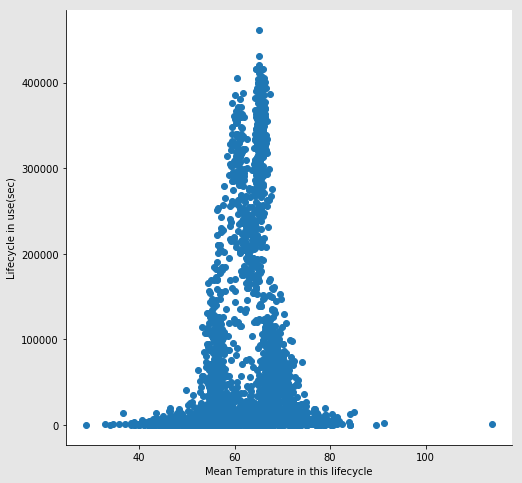

In [64]:
fig, ax = plt.subplots(figsize = [8,8], facecolor=[0.9,0.9,0.9])

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


x_axis=lifecycle_weather.Tempbyduration
y_axis=lifecycle_weather.duration

ax.scatter(x_axis, y_axis)
plt.xlabel('Mean Temprature in this lifecycle')
plt.ylabel('Lifecycle in use(sec)')

plt.show()

### Dew point vs lifecycle

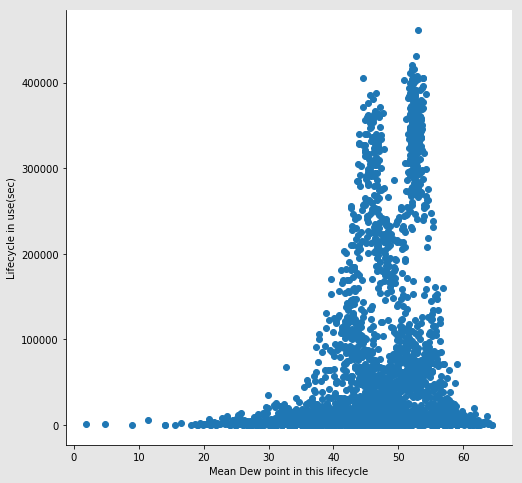

In [65]:
fig, ax = plt.subplots(figsize = [8,8], facecolor=[0.9,0.9,0.9])

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


x_axis=lifecycle_weather.Dewbyduration
y_axis=lifecycle_weather.duration

ax.scatter(x_axis, y_axis)
plt.xlabel('Mean Dew point in this lifecycle')
plt.ylabel('Lifecycle in use(sec)')

plt.show()

### Humidity vs lifecycle

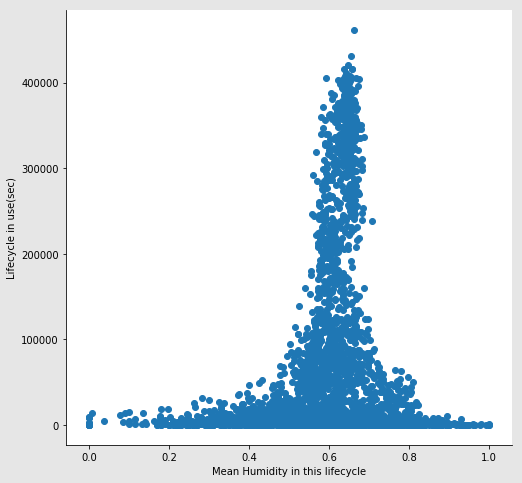

In [67]:
fig, ax = plt.subplots(figsize = [8,8], facecolor=[0.9,0.9,0.9])

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


x_axis=lifecycle_weather.Humibyduration
y_axis=lifecycle_weather.duration

ax.scatter(x_axis, y_axis)
plt.xlabel('Mean Humidity in this lifecycle')
plt.ylabel('Lifecycle in use(sec)')

plt.show()

### Pressure vs lifecycle

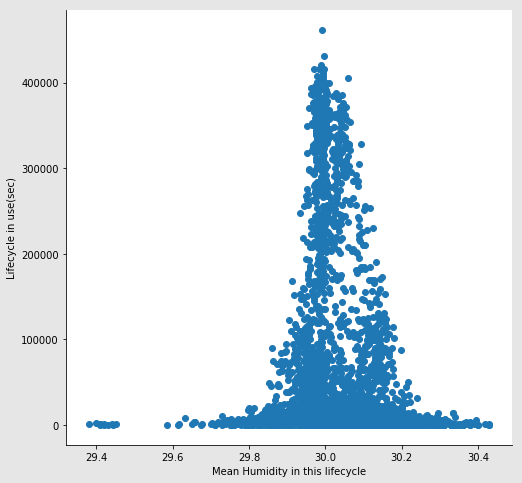

In [68]:
fig, ax = plt.subplots(figsize = [8,8], facecolor=[0.9,0.9,0.9])

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


x_axis=lifecycle_weather.Presbyduration
y_axis=lifecycle_weather.duration

ax.scatter(x_axis, y_axis)
plt.xlabel('Mean Humidity in this lifecycle')
plt.ylabel('Lifecycle in use(sec)')

plt.show()

### Visibility vs lifecycle

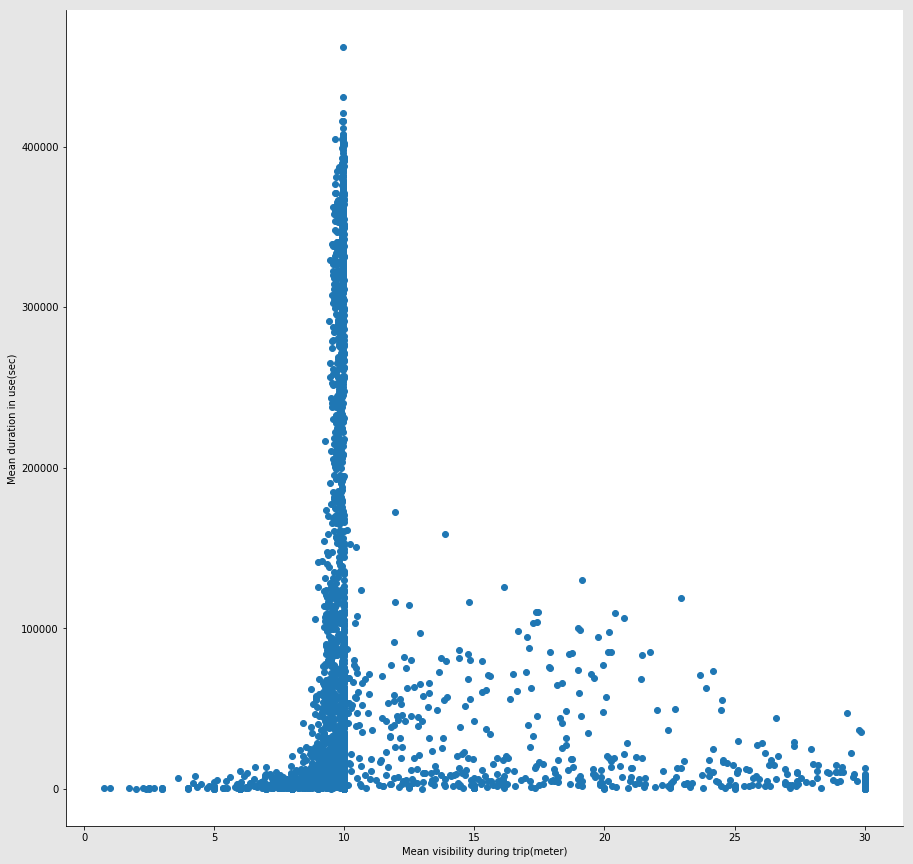

In [69]:
fig, ax = plt.subplots(figsize = [15,15], facecolor=[0.9,0.9,0.9])

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
#ax.spines['bottom'].set_position(('data',0)) # set position of x spine to x=0

ax.yaxis.set_ticks_position('left')
#ax.spines['left'].set_position(('data',0))   # set position of y spine to y=0

x_axis=lifecycle_weather.Visibyduration
y_axis=lifecycle_weather.duration

ax.scatter(x_axis, y_axis)
plt.xlabel('Mean visibility during trip(meter)')
plt.ylabel('Mean duration in use(sec)')
#plt.title('Scatter plot of household head education & average enrollment rate (1997)')

plt.show()

In general, except Visibility which has a normal distribution shape, other weather factors all have a bimodal shape. It is difficult to find a distinct linear relationship between a weather factor and the lifecycle. All we can determine is that the long lifecycle would not happen when the weather factor is near its minimum value and its maximum value.


### PCA

Furthermore, we use PCA to combine these four factors except Visibility and reduce the dimensionality to get a “weather index” to represent the weather information. 


In [70]:
# standardize the data
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [72]:
t = standardize(lifecycle_weather[['Tempbyduration', 'Humibyduration', 'Presbyduration', 'Dewbyduration']])
pca = PCA(n_components=2)
pca.fit(t)
WeatherIndex = pd.DataFrame(pca.fit_transform(t))
pca.explained_variance_ratio_

array([ 0.53160016,  0.3214073 ])

To maintain the variance, we decided to reduce the dimensionality to 2, which can maintain 85% variance. Since we have 2 dimensions and 1 target, we generated a 3D plot to explore the relationship as below.

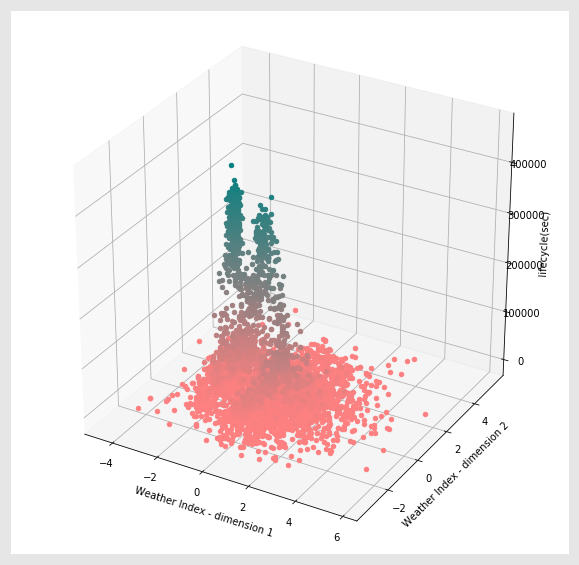

In [76]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = [10,10], facecolor=[0.9,0.9,0.9])
ax = fig.gca(projection='3d')
data = zip(WeatherIndex[0], WeatherIndex[1], lifecycle_weather.duration)
for x,y,z in data:
    col = ((lifecycle_weather.duration.max()-z)/(lifecycle_weather.duration.max()-lifecycle_weather.duration.min()))

    ax.scatter(x,y,z,c=[(col,0.5,0.5),], marker='o')
ax.set_xlabel('Weather Index - dimension 1')
ax.set_ylabel('Weather Index - dimension 2')
ax.set_zlabel('lifecycle(sec)')

plt.show()

According to the above plot, we could see the long life cycle still remains at the center section of the weather index. But, at the same time, it could not determin whether a short life cycle would happen based on the weather index. 